## usage

In [1]:
## Imports
import sys, os
sys.path.append('..')

# import numpy as np
# import bilby
from gwtoolkit.gw import WaveformDataset
# from gwtoolkit.gw import Priors
# from gwtoolkit.gw import Source
# from gwtoolkit.gw import Detector
import matplotlib.pyplot as plt
sys.version

'3.8.10 | packaged by conda-forge | (default, May 10 2021, 22:58:09) \n[Clang 11.1.0 ]'

In [2]:
wfd = WaveformDataset(sampling_frequency=4096, duration=8, conversion='BBH')
waveform_arguments = dict(waveform_approximant='IMRPhenomPv2',
                          reference_frequency=150., 
                          minimum_frequency=20.)
wfd.load_prior_source_detector(#filename='../gwtoolkit/gw/prior_files/default.prior',
    base='bilby',
    dets=['H1', 'L1'], 
    waveform_arguments=waveform_arguments)

15:51 bilby INFO    : No prior given, using default BBH priors in /Users/herb/miniconda3/envs/gwtoolkit/gwtoolkit/lib/python3.8/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


No prior given, using default BBH priors.


In [3]:
signal_freq, meta, noise_freq = wfd.frequency_waveform_response_block(100, 100, (101,102), (0, 30)
                                                )
data_freq = signal_freq + noise_freq
signal_freq.shape, noise_freq.shape

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.77it/s]


((100, 2, 16385), (100, 2, 16385))

In [1]:
num = 10
signal_time, meta, noise_time = wfd.time_waveform_response_block(num, 100, (105,106), (0, 30)
                                                )
data_time = signal_time + noise_time
signal_time.shape, noise_time.shape

NameError: name 'wfd' is not defined

(30.0, (29.588657-0.66100454j))

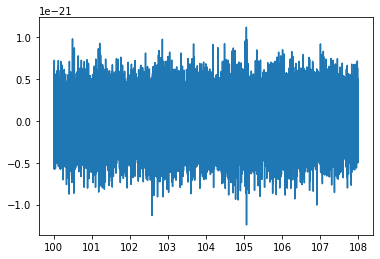

In [5]:
i = 0
plt.plot(wfd.time_array, signal_time[i,0]+noise_time[i,0])
meta['optimal_snr'][i,0], meta['matched_filter_snr'][i,0]

## gwsurrogate

In [15]:
import gwsurrogate
import numpy as np

In [9]:
gwsurrogate.catalog.list()

EOBNRv2
SpEC_q1_10_NoSpin
SpEC_q1_10_NoSpin_linear
SpEC_q1_10_NoSpin_linear_alt
NRSur4d2s_TDROM_grid12
NRSur4d2s_FDROM_grid12
NRHybSur3dq8
NRSur7dq4
NRHybSur3dq8Tidal
EMRISur1dq1e4


In [10]:
class nrhybsur3dq8_wrapper(object):

    def __init__(self):

        if not os.path.exists(gwsurrogate.__path__[0]+'/surrogate_downloads/NRHybSur3dq8.h5'):
            gwsurrogate.catalog.pull('NRHybSur3dq8')

        self.sur    = gwsurrogate.LoadSurrogate('NRHybSur3dq8')

    def __call__(self, freqs, params):
        hp, hc, dt      = self.td_waveform(params)
        return hp, hc

    def td_waveform(self, params):
        srate = params['srate']
        chiA = [params['s1x'],params['s1y'],params['s1z']]
        chiB = [params['s2x'],params['s2y'],params['s2z']]
        
        if params['lmax'] < 2:
            params['lmax'] = 2

        t, h, dyn = self.sur(params['q'], chiA, chiB,
                             dt         = 1./srate,
                             # if f_low, start from the minimum freq of the surrogate
                             # without f_ref, f_ref = f_low
                             f_low      = 0,
                             ellMax     = params['lmax'],
                             M          = params['mtot'],
                             dist_mpc   = params['distance'],
                             inclination = params['iota'],
                             phi_ref    = params['phi_ref'],
                             tidal_opts = {'Lambda1': 0.,
                                           'Lambda2': 0.},
                             units      = 'mks',
                             skip_param_checks = True)

        hp = h.real
        hc = h.imag
        dt = np.median(np.diff(t))
        return hp, hc, dt

In [11]:
wave_func  = nrhybsur3dq8_wrapper()

Loaded NRHybSur3dq8 model


In [ ]:
wave_func()

In [12]:
gwsurrogate.__path__[0]

'/Users/herb/miniconda3/envs/gwtoolkit/gwtoolkit/lib/python3.8/site-packages/gwsurrogate'

In [37]:
class nrsur7dq4_wrapper(object):

    def __init__(self):

        if not os.path.exists(gwsurrogate.__path__[0]+'/surrogate_downloads/NRSur7dq4.h5'):
            gwsurrogate.catalog.pull('NRSur7dq4')

        self.sur    = gwsurrogate.LoadSurrogate('NRSur7dq4')

    def __call__(self, freqs, params):
        hp, hc, dt      = self.td_waveform(params)
        return hp, hc

    def td_waveform(self, params):
        srate = params['srate']
        chiA = [params['s1x'],params['s1y'],params['s1z']]
        chiB = [params['s2x'],params['s2y'],params['s2z']]
        
#         if params['lmax'] < 2:
#             params['lmax'] = 2

        t, h, dyn = self.sur(params['q'], chiA, chiB,
                             dt         = 1./srate,
                             # if f_low, start from the minimum freq of the surrogate
                             # without f_ref, f_ref = f_low
                             f_low      = 0,
                             #ellMax     = params['lmax'],
                             M          = params['mtot'],
                             dist_mpc   = params['distance'],
                             inclination = params['iota'],
                             phi_ref    = params['phi_ref'],
                             tidal_opts = {'Lambda1': params['lambda1'],
                                           'Lambda2': params['lambda2']},
                             units      = 'mks',
                             skip_param_checks = True)

        hp = h.real
        hc = h.imag
        dt = np.median(np.diff(t))
        return hp, hc, dt

In [38]:
wave_func  = nrsur7dq4_wrapper()

Loaded NRSur7dq4 model


In [39]:
# set the data properties coherently
seglen = 8           # duration of the segment [s]
srate  = 4096         # sampling rate [Hz]
t_gps  = 1126259462   # central value of GPS time
f_max  = 1024
f_min  = 20 

params = {'mtot':30,
          'mchirp'     : 30.,    # chirp mass [solar masses]
          'q'          : 1.2,      # mass ratio 
          's1x'        : 0.,      # primary spin parameter, x component
          's1y'        : 0.,      # primary spin parameter, y component
          's1z'        : 0.,      # primary spin parameter, z component
          's2x'        : 0.,      # secondary spin parameter, x component
          's2y'        : 0.,      # secondary spin parameter, y component
          's2z'        : 0.,      # secondary spin parameter, z component
          'lambda1'    : 0.,      # primary tidal parameter 
          'lambda2'    : 0 ,      # secondary tidal parameter
          'distance'   : 380.,    # distance [Mpc]
          'iota'       : np.pi,   # inclination [rad]
          'ra'         : 1.7,     # right ascension [rad]
          'dec'        : -0.75,   # declination [rad]
          'psi'        : 0.,      # polarization angle [rad]
          'time_shift' : 0.419,   # time shift from GPS time [s]
          'phi_ref'    : 0.,     # phase shift [rad]
          'f_min'      : 20.,     # minimum frequency [Hz]
          'srate'      : srate,   # sampling rate [Hz]
          'seglen'     : seglen,  # segment duration [s] 
          'tukey'      : 0.1,     # parameter for tukey window 
          't_gps'      : t_gps }  # GPS trigger time 

In [40]:
hp, hc = wave_func(wfd.frequency_array, params)

In [41]:
hp, hc

(array([-2.27837175e-22, -2.27320586e-22, -2.26488862e-22, ...,
        -6.99852606e-25, -7.19495180e-25, -3.31718111e-25]),
 array([-5.42735962e-26, -1.22309128e-23, -2.43758381e-23, ...,
         5.11899057e-25, -1.67717826e-25, -5.55842261e-25]))

In [4]:
gwsurrogate.catalog.pull('NRSur7dq4')       # This can take a few minutes

'/Users/herb/miniconda3/envs/gwtoolkit/gwtoolkit/lib/python3.8/site-packages/gwsurrogate/surrogate_downloadsNRSur7dq4.h5'

In [5]:
sur = gwsurrogate.LoadSurrogate('NRSur7dq4')

Loaded NRSur7dq4 model


In [6]:
q = 4           # mass ratio, mA/mB >= 1.
chiA = [-0.2, 0.4, 0.1]         # Dimensionless spin of heavier BH
chiB = [-0.5, 0.2, -0.4]        # Dimensionless of lighter BH
dt = 0.1                        # timestep size, Units of total mass M
f_low = 0                # initial frequency, f_low=0 returns the full surrogate

# h is dictionary of spin-weighted spherical harmonic modes
# t is the corresponding time array in units of M
# dyn stands for dynamics, do dyn.keys() to see contents
t, h, dyn = sur(q, chiA, chiB, dt=dt, f_low=f_low)

In [22]:
wfd.dets['CE']._show_detectors()

Interferometer(name='CE',
power_spectral_density=PowerSpectralDensity(psd_file='/Users/herb/miniconda3/envs/gwtoolkit/lib/python3.8/site-packages/bilby/gw/detector/noise_curves/CE_psd.txt',
asd_file='None'),
minimum_frequency=10.0,
maximum_frequency=2048.0,
length=40.0,
latitude=46.45514666666667,
longitude=-119.4076571388889,
elevation=142.554,
xarm_azimuth=125.9994,
yarm_azimuth=215.994,
xarm_tilt=-0.0006195,
yarm_tilt=1.25e-05)


In [23]:
wfd.prior._show_priors()

{'mass_1': Constraint(minimum=5, maximum=100, name='mass_1', latex_label='$m_1$', unit=None),
 'mass_2': Constraint(minimum=5, maximum=100, name='mass_2', latex_label='$m_2$', unit=None),
 'mass_ratio': Uniform(minimum=0.125, maximum=1, name='mass_ratio', latex_label='$q$', unit=None, boundary=None),
 'chirp_mass': Uniform(minimum=25, maximum=100, name='chirp_mass', latex_label='$\\mathcal{M}$', unit=None, boundary=None),
 'luminosity_distance': UniformSourceFrame(minimum=100.0, maximum=5000.0, cosmology=FlatLambdaCDM(name="Planck15", H0=67.7 km / (Mpc s),
 Om0=0.307, Tcmb0=2.725 K, Neff=3.05, m_nu=[0.   0.   0.06] eV, Ob0=0.0486),
 name='luminosity_distance', latex_label='$d_L$', unit=Unit("Mpc"),
 boundary=None),
 'dec': Cosine(minimum=-1.5707963267948966, maximum=1.5707963267948966, name='dec', latex_label='$\\mathrm{DEC}$', unit=None, boundary=None),
 'ra': Uniform(minimum=0, maximum=6.283185307179586, name='ra', latex_label='$\\mathrm{RA}$', unit=None, boundary='periodic'),
 'thet

In [24]:
p = wfd.prior.sample(1)
p

{'mass_ratio': array([0.56235766]),
 'chirp_mass': array([55.12470499]),
 'luminosity_distance': array([2536.17209965]),
 'dec': array([-0.60877086]),
 'ra': array([5.18572181]),
 'theta_jn': array([2.08962604]),
 'psi': array([2.49968139]),
 'phase': array([2.65426913]),
 'a_1': array([0.15697504]),
 'a_2': array([0.61185221]),
 'tilt_1': array([2.3792065]),
 'tilt_2': array([1.99373613]),
 'phi_12': array([1.56725853]),
 'phi_jl': array([1.00391779])}

In [25]:
wfd.update_waveform()
wfd.frequency_waveform_polarizations, wfd.time_waveform_polarizations

({'plus': array([0.-0.j, 0.-0.j, 0.-0.j, ..., 0.-0.j, 0.-0.j, 0.-0.j]),
  'cross': array([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j])},
 {'plus': array([ 1.55077504e-23,  2.42364034e-23,  3.14356387e-23, ...,
         -1.63268904e-23, -5.19282491e-24,  5.56790257e-24]),
  'cross': array([-2.31950979e-23, -1.97021246e-23, -1.53060005e-23, ...,
         -2.63797343e-23, -2.66760637e-23, -2.55756991e-23])})

In [26]:
wfd.update_noise()
wfd.frequency_colored_noise, wfd.time_colored_noise

(array([[ 0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j, ...,
          4.00214791e-25-6.11164195e-24j,  3.04175069e-24+4.00859859e-24j,
          0.00000000e+00+0.00000000e+00j],
        [ 0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j, ...,
         -2.54919070e-24-5.13864427e-24j,  1.55211780e-24-6.29030592e-24j,
          0.00000000e+00+0.00000000e+00j],
        [ 0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j, ...,
         -3.69754386e-25-5.19169702e-25j,  2.86935030e-25-4.49013241e-25j,
          0.00000000e+00+0.00000000e+00j]]),
 array([[-2.20586969e-23, -1.33141872e-22,  9.72453525e-24, ...,
         -5.65085569e-22,  3.74495194e-22, -1.82876197e-22],
        [-5.37118770e-23,  4.74046402e-22, -2.31678658e-22, ...,
          2.33567570e-22,  1.99947942e-23,  2.51342984e-22],
        [-3.41914396e-23, 

In [27]:
wfd.update_detector_response(start_time=99, geocent_time=(100, 101))
wfd.frequency_waveform_response, wfd.time_waveform_response

(array([[0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]]),
 array([[-9.12753413e-24, -9.00769666e-24, -8.87928409e-24, ...,
         -9.43472745e-24, -9.34112887e-24, -9.23870591e-24],
        [ 9.60152523e-24,  9.38919949e-24,  9.16773432e-24, ...,
          1.01819665e-23,  9.99807042e-24,  9.80453748e-24],
        [-9.12801346e-24, -9.00819999e-24, -8.87981101e-24, ...,
         -9.43513251e-24, -9.34155904e-24, -9.23916084e-24]]))

In [12]:
ff = wfd.frequency_colored_noise_block(1000)
ff.shape

100%|███████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 709.87it/s]


(1000, 2, 4097)

In [14]:
tt = wfd.time_colored_noise_block(1000)
tt.shape

100%|███████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 660.29it/s]


(1000, 2, 8192)

In [59]:
ff = wfd.frequency_whitened_noise_block(1000)  
tt = wfd.time_whitened_noise_block(1000)

100%|███████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 385.22it/s]


In [30]:
ff, meta = wfd.frequency_waveform_response_block(100, 100, (101,102),# (0, 30)
                                                )
ff.shape

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.16it/s]


(100, 3, 2049)

In [29]:
tt, meta = wfd.time_waveform_response_block(100, 100, (101,102), #(0, 30)
                                           )
tt.shape

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 34.18it/s]


(100, 3, 4096)

In [61]:
meta.keys()

dict_keys(['mass_ratio', 'chirp_mass', 'luminosity_distance', 'dec', 'ra', 'theta_jn', 'psi', 'phase', 'a_1', 'a_2', 'tilt_1', 'tilt_2', 'phi_12', 'phi_jl', 'geocent_time', 'matched_filter_snr', 'optimal_snr'])

In [14]:
# ff, _  = wfd.dets['H1'].time_to_frequency_domain(tt[-3][0])
# wfd.dets['H1'].optimal_snr(ff)

In [13]:
# ff, _  = wfd.dets['L1'].time_to_frequency_domain(tt[-3][1])
# wfd.dets['L1'].optimal_snr(ff)

In [15]:
meta['optimal_snr'], meta['optimal_snr'].shape

NameError: name 'meta' is not defined

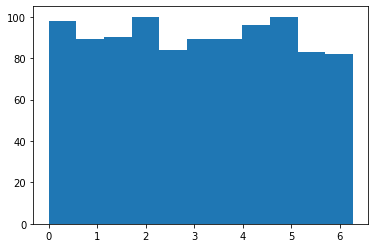

In [19]:
import matplotlib.pyplot as plt
plt.hist(meta['ra'], bins='auto');

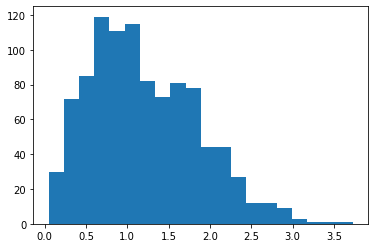

In [16]:
import matplotlib.pyplot as plt
plt.hist(abs(meta['matched_filter_snr'])[:,0], bins='auto');

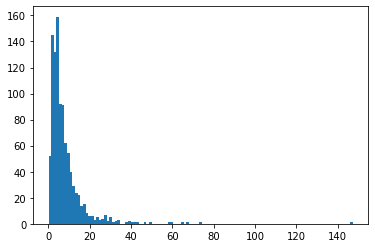

In [18]:
import matplotlib.pyplot as plt
plt.hist(meta['optimal_snr'][:,0], bins='auto');

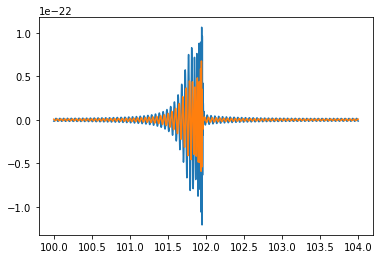

In [17]:
import matplotlib.pyplot as plt
n= 2
plt.plot(wfd.time_array, tt[n,0])
plt.plot(wfd.time_array, tt[n,1]);

/Users/herb/miniconda3/envs/gwtoolkit/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/herb/miniconda3/envs/gwtoolkit/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


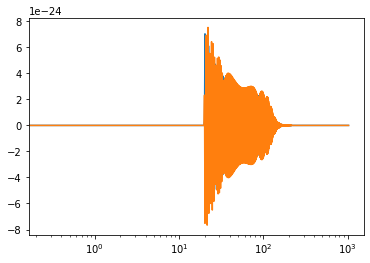

In [21]:
import matplotlib.pyplot as plt
n= 0
plt.plot(wfd.frequency_array, ff[n,0])
plt.plot(wfd.frequency_array, ff[n,1])
plt.xscale('log');

In [13]:
injection_parameters = dict(
    mass_1=36., mass_2=29., 
#     mass_ratio=0.5, chirp_mass=29,
    a_1=0.4, a_2=0.3, tilt_1=0.5, tilt_2=1.0,
    phi_12=1.7, phi_jl=0.3, luminosity_distance=2000., theta_jn=0.4, psi=2.659,
    phase=1.3, geocent_time=1126259642.413, ra=1.375, dec=-1.2108)

In [70]:
wfd.parameters= wfd.prior.sample_subset(['mass_1', 'mass_2', 'mass_ratio', 'chirp_mass', 
                                         'a_1', 'a_2', 'tilt_1',
                                         'tilt_2', 'phi_12', 'phi_jl',
                                         'luminosity_distance', 'theta_jn', 'phase'], 1)

In [63]:
wfd.frequency_waveform_polarizations

{'plus': array([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]),
 'cross': array([0.-0.j, 0.-0.j, 0.-0.j, ..., 0.-0.j, 0.-0.j, 0.-0.j])}

In [71]:
wfd.time_waveform_polarizations

{'plus': array([ 7.28935428e-23,  8.73083073e-23,  9.23547470e-23, ...,
        -1.46217860e-23,  1.97607681e-23,  4.98056659e-23]),
 'cross': array([4.74555813e-23, 3.35806002e-23, 1.87903685e-23, ...,
        6.86100525e-23, 6.62435087e-23, 5.88228077e-23])}

In [29]:
# Set the duration and sampling frequency of the data segment that we're
# going to inject the signal into
duration = 4.
sampling_frequency = 2048.

injection_parameters = dict(
    mass_1=36., mass_2=29., 
#     mass_ratio=0.5, chirp_mass=29,
    a_1=0.4, a_2=0.3, tilt_1=0.5, tilt_2=1.0,
    phi_12=1.7, phi_jl=0.3, luminosity_distance=2000., theta_jn=0.4, psi=2.659,
    phase=1.3, geocent_time=1126259642.413, ra=1.375, dec=-1.2108)

In [31]:
wfg = source.waveform_generator(wfd.prior.sample(1))
wfg.frequency_domain_strain(), wfg.time_domain_strain()

({'plus': array([0.-0.j, 0.-0.j, 0.-0.j, ..., 0.-0.j, 0.-0.j, 0.-0.j]),
  'cross': array([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j])},
 {'plus': array([-2.73469244e-22, -3.88440837e-22, -4.32773128e-22, ...,
          2.87918322e-22,  9.71813609e-23, -1.02292526e-22]),
  'cross': array([-2.63327677e-22, -7.71392050e-23,  1.02092240e-22, ...,
         -5.16546356e-22, -5.12745735e-22, -4.20021224e-22])})

In [32]:
source = Source(base='bilby', conversion='BBH', sampling_frequency=2048, duration=4)
wfg = source.waveform_generator(injection_parameters)
wfg.frequency_domain_strain(), wfg.time_domain_strain()

({'plus': array([0.-0.j, 0.-0.j, 0.-0.j, ..., 0.-0.j, 0.-0.j, 0.-0.j]),
  'cross': array([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j])},
 {'plus': array([-9.02574812e-23,  3.23870514e-23,  1.02775708e-22, ...,
          3.04225764e-24, -1.43791761e-22, -1.75067200e-22]),
  'cross': array([-1.23160024e-22, -1.26431294e-22, -4.34664366e-23, ...,
          2.13429423e-22,  1.33757284e-22, -1.50055656e-23])})

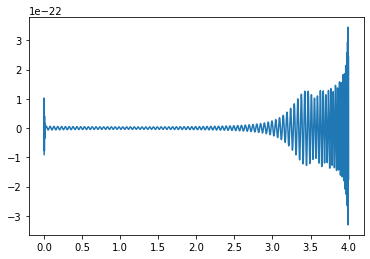

In [6]:
import matplotlib.pyplot as plt
plt.plot(wfg.time_array, wfg.time_domain_strain()['plus'])

/Users/herb/miniconda3/envs/gwtoolkit/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


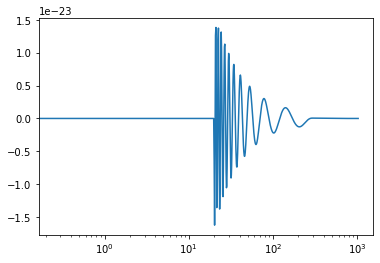

In [7]:
plt.plot(wfg.frequency_array, wfg.frequency_domain_strain()['plus'])
plt.xscale('log')

In [10]:
wfg = source.waveform_generator(wfd.priors.sample(1))
wfg.parameters

NameError: name 'source' is not defined

In [9]:
wfg.time_domain_strain()

{'plus': array([-6.20869555e-23, -4.17096325e-23, -1.57771425e-23, ...,
        -4.41041094e-23, -6.55101114e-23, -7.12661097e-23]),
 'cross': array([-1.15382854e-24,  2.19764513e-23,  3.83610931e-23, ...,
        -6.21684519e-23, -4.86716745e-23, -2.65472458e-23])}

In [10]:
det = Detector('H1', sampling_frequency=4096, duration=1, start_time=10)
det.time_domain_strain

array([-4.23987948e-23, -1.77697531e-22, -3.64461532e-22, ...,
        1.45793998e-22, -3.68926115e-22,  2.08160839e-22])

In [11]:
det.update(duration=8, sampling_frequency=4096*2)
det.time_domain_strain.shape, det.frequency_domain_strain.shape

((65536,), (32769,))

In [47]:
freq_strain, freq = det.time_to_frequency_domain(det.time_domain_strain)
tim_strain, tim = det.frequency_to_time_domain(det.frequency_domain_strain)

In [ ]:
psd_file = '/Users/herb/miniconda3/envs/gwtoolkit/lib/python3.8/site-packages/bilby/gw/detector/noise_curves/AdV_psd.txt'
det.load_asd_or_psd_file(psd_file=psd_file)

In [20]:
# wfd.priors.sample(1)

In [77]:
det.update(duration=4, sampling_frequency=2048, start_time=20)

In [81]:
det.get_detector_response(wfg.frequency_domain_strain(), injection_parameters)

array([ 0.+0.j,  0.+0.j,  0.+0.j, ...,  0.+0.j,  0.+0.j, -0.+0.j])

In [65]:
len(wfg.frequency_array)

4097

In [83]:
det.ifo.strain_data.minimum_frequency = 20

In [72]:
det.ifo.minimum_frequency = 20

In [84]:
det.ifo.strain_data._frequency_mask_updated

False

In [67]:
det.ifo

Interferometer(name='H1', power_spectral_density=PowerSpectralDensity(psd_file='/Users/herb/miniconda3/envs/gwtoolkit/lib/python3.8/site-packages/bilby/gw/detector/noise_curves/AdV_psd.txt', asd_file='/Users/herb/miniconda3/envs/gwtoolkit/lib/python3.8/site-packages/bilby/gw/detector/noise_curves/aLIGO_O4_high_asd.txt'), minimum_frequency=20.0, maximum_frequency=1024.0, length=4.0, latitude=46.45514666666667, longitude=-119.4076571388889, elevation=142.554, xarm_azimuth=125.9994, yarm_azimuth=215.9994, xarm_tilt=-0.0006195, yarm_tilt=1.25e-05)

In [63]:
det.ifo.frequency_array.shape

(4097,)

/Users/herb/miniconda3/envs/gwtoolkit/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


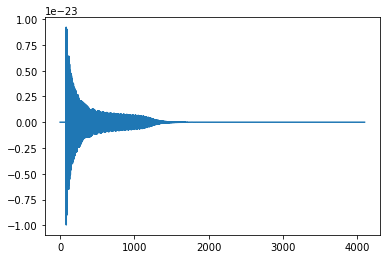

In [602]:
plt.plot(_)

In [85]:
det._show_detectors()

Interferometer(name='H1',
power_spectral_density=PowerSpectralDensity(psd_file='/Users/herb/miniconda3/envs/gwtoolkit/lib/python3.8/site-packages/bilby/gw/detector/noise_curves/AdV_psd.txt',
asd_file='/Users/herb/miniconda3/envs/gwtoolkit/lib/python3.8/site-packages/bilby/gw/detector/noise_curves/aLIGO_O4_high_asd.txt'),
minimum_frequency=20.0,
maximum_frequency=1024.0,
length=4.0,
latitude=46.45514666666667,
longitude=-119.4076571388889,
elevation=142.554,
xarm_azimuth=125.9994,
yarm_azimuth=215.9994,
xarm_tilt=-0.0006195,
yarm_tilt=1.25e-05)


In [9]:
wfd.priors.append_uniform_prior('geocent_time', 100, 101, latex_label='$t_c$', unit='$s$')

In [35]:
wfs = Source(base='bilby', conversion='BBH', sampling_frequency=2048, duration=4)
param = wfd.prior.sample()
wfg = wfs.waveform_generator(param)
wfg.frequency_domain_strain()

{'plus': array([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]),
 'cross': array([0.-0.j, 0.-0.j, 0.-0.j, ..., 0.-0.j, 0.-0.j, 0.-0.j])}

In [36]:
det = Detector(name='H1', sampling_frequency=2048, duration=4, start_time=98)
signal = det.get_detector_response(wfg.frequency_domain_strain(), param)

In [50]:
wfg.frequency_domain_strain()['plus'].dtype

dtype('complex128')

In [37]:
det.update()
noise = det.frequency_domain_strain
signal + noise

array([0.00000000e+00+0.0000000e+00j, 0.00000000e+00+0.0000000e+00j,
       0.00000000e+00+0.0000000e+00j, ..., 3.24743483e-25-1.2808560e-24j,
       1.59259009e-24+1.5953396e-25j, 0.00000000e+00+0.0000000e+00j])

In [40]:
signal

array([ 0.+0.j,  0.+0.j,  0.+0.j, ...,  0.+0.j, -0.+0.j,  0.+0.j])

In [38]:
det.update()
np.sqrt(det.ifo.optimal_snr_squared(signal).real)

11.892456616771579

In [14]:
# det.update()
det.ifo.matched_filter_snr(signal)

(0.6911335649521316+0.7562782770149682j)

In [30]:
det.frequency_domain_strain.shape

(4097,)

In [33]:
det.whitened_frequency_domain_strain()

array([ 0.        +0.j        ,  0.        +0.j        ,
        0.        +0.j        , ..., -0.45094479-0.32583294j,
       -1.29005841-1.77015593j,  0.        +0.j        ])

## test bilby

In [36]:
import bilby
sampling_frequency = 4096
duration = 8
injection_parameters = dict(
    mass_1=36., mass_2=29., 
#     mass_ratio=0.5, chirp_mass=29,
    a_1=0.4, a_2=0.3, tilt_1=0.5, tilt_2=1.0,
    phi_12=1.7, phi_jl=0.3, luminosity_distance=2000., theta_jn=0.4, psi=2.659,
    phase=1.3, geocent_time=1126259642.413, ra=1.375, dec=-1.2108)

In [37]:
# Fixed arguments passed into the source model
waveform_arguments = dict(waveform_approximant='IMRPhenomPv2',
                          reference_frequency=50., 
                          minimum_frequency=20.)

In [38]:
# Create the waveform_generator using a LAL BinaryBlackHole source function
# the generator will convert all the parameters
waveform_generator = bilby.gw.WaveformGenerator(
    parameters=injection_parameters,
    duration=duration, sampling_frequency=sampling_frequency,
    frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
    parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
    waveform_arguments=waveform_arguments)

In [39]:
# Set up interferometers.  In this case we'll use two interferometers
# (LIGO-Hanford (H1), LIGO-Livingston (L1). These default to their design
# sensitivity
ifos = bilby.gw.detector.InterferometerList(['H1', 'L1'])
ifos.set_strain_data_from_power_spectral_densities(
    sampling_frequency=sampling_frequency, duration=duration,
    start_time=injection_parameters['geocent_time'] - 3)

ifos.inject_signal(waveform_generator=waveform_generator,
                   parameters=injection_parameters)


[{'plus': array([0.-0.j, 0.-0.j, 0.-0.j, ..., 0.-0.j, 0.-0.j, 0.-0.j]),
  'cross': array([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j])},
 {'plus': array([0.-0.j, 0.-0.j, 0.-0.j, ..., 0.-0.j, 0.-0.j, 0.-0.j]),
  'cross': array([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j])}]

In [42]:
ifos[0].meta_data

{'optimal_SNR': 11.774637533551406,
 'matched_filter_SNR': (13.39358934657477+1.5809327398727067j),
 'parameters': {'mass_1': 36.0,
  'mass_2': 29.0,
  'a_1': 0.4,
  'a_2': 0.3,
  'tilt_1': 0.5,
  'tilt_2': 1.0,
  'phi_12': 1.7,
  'phi_jl': 0.3,
  'luminosity_distance': 2000.0,
  'theta_jn': 0.4,
  'psi': 2.659,
  'phase': 1.3,
  'geocent_time': 1126259642.413,
  'ra': 1.375,
  'dec': -1.2108}}

In [43]:
wfd = WaveformDataset(sampling_frequency=4096, duration=8, conversion='BBH')
waveform_arguments = dict(waveform_approximant='IMRPhenomPv2',
                          reference_frequency=50., 
                          minimum_frequency=20.)
wfd.load_prior_source_detector(#filename='../gwtoolkit/gw/prior_files/default.prior',
    base='bilby',
    dets=['H1', 'L1'], 
    waveform_arguments=waveform_arguments)

No prior given, using default BBH priors.


In [57]:
_, meta = wfd.frequency_waveform_response_block(1, injection_parameters['geocent_time'] - 3, 
                                      [injection_parameters['geocent_time']-2, injection_parameters['geocent_time']-1],
                                      (0, 30))
meta

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.03it/s]


{'mass_ratio': array([0.42962267]),
 'chirp_mass': array([28.03758328]),
 'luminosity_distance': array([4278.91215043]),
 'dec': array([-0.30952457]),
 'ra': array([5.0379718]),
 'theta_jn': array([1.00178513]),
 'psi': array([2.73461423]),
 'phase': array([3.2801195]),
 'a_1': array([0.32018444]),
 'a_2': array([0.42783432]),
 'tilt_1': array([1.75864584]),
 'tilt_2': array([1.78939609]),
 'phi_12': array([0.78528744]),
 'phi_jl': array([5.45281429]),
 'geocent_time': array([1.12625964e+09]),
 'matched_filter_snr': array([[-0.28133044-2.8676481j , -0.2554906 +0.93297327j]],
       dtype=complex64),
 'optimal_snr': array([[30.        , 47.93426129]])}

In [3]:
import numpy as np
import pandas as pd
import urllib

In [4]:
def CatchGPS(event):
    
    # 这部分代码会从网络上自动下载 JSON 数据

    f = urllib.request.urlopen('https://www.gw-openscience.org/eventapi/json/allevents/')
    allevents = json.loads(f.read())['events']

    event_version = sorted([key for key, value in allevents.items() if event in key.split('-')[0]], 
                           key=lambda x: int(x.split('-')[-1][-1]), reverse=True)[0]
    assert allevents[event_version]['commonName'] == event

    # detectors
    f = urllib.request.urlopen(allevents[event_version]['jsonurl'])
    events_meta = json.loads(f.read())['events'][event_version]

    t_event = events_meta['GPS'] # GPS time of coalescence
    print(t_event)    
    detectors=sorted(list(set([meta['detector'] for meta in events_meta['strain']])))
    print(detectors)
    return t_event, detectors, events_meta

In [20]:
# event = 'GW150914'
# f = urllib.request.urlopen('https://www.gw-openscience.org/eventapi/json/allevents/')
# allevents = json.loads(f.read())['events']

In [21]:
# event = 'GW150914'
# t_event, detectors, events_meta = CatchGPS(event) 